In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

## Problem

The problem is to use distribuiton to mimic people's behavior of how many books he read each day. The data is generate aritifically. See the code below

Count Data Mean:  19.743244


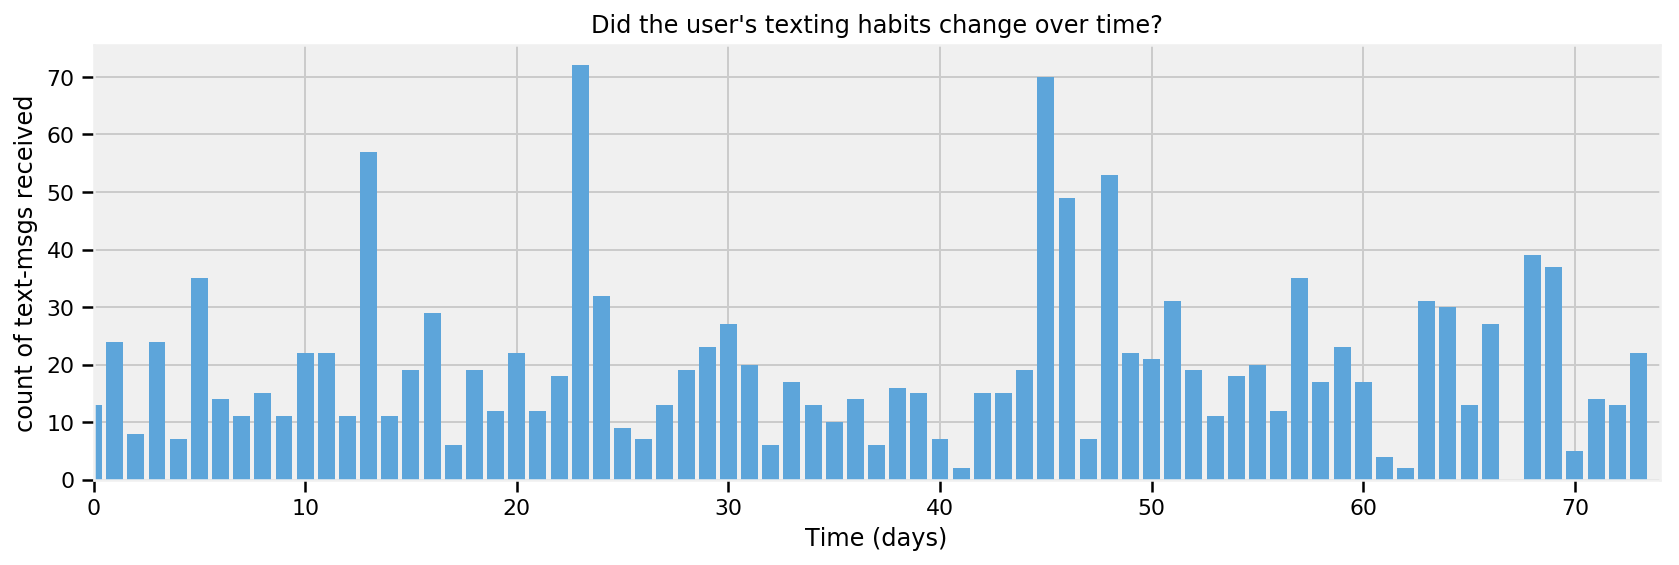

In [2]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
count_data_mean = tf.reduce_mean(count_data)
n_count_data = tf.shape(count_data)
count_of_text_msgs = tf.range(n_count_data[0])

# Convert from TF to numpy.
[
    count_data_, 
    count_data_mean_,
    n_count_data_, 
    count_of_text_msgs_,
] = evaluate([
    count_data, 
    count_data_mean,
    n_count_data,
    count_of_text_msgs,
])

# Visualizing the Results    
plt.figure(figsize=(12.5, 4))
plt.bar(count_of_text_msgs_, count_data_, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data_[0]);

print("Count Data Mean: ", count_data_mean_)

Usually, we use poisson-distribution to fit the data. The definition of poisson-distribution is showing below.

*Poisson*-distributed

$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

If a random variable $Z$ has a Poisson mass distribution, we denote this by writing
 
$$Z \sim \text{Poisson}(\lambda) $$

With tenserflow probability module we can easily apply mcmc algorithm to modify our distribuiton and generate the best result

In [3]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    alpha = np.array(1. / count_data.mean(), np.float32)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    rv_tau = tfd.Uniform()
    
    lambda_ = tf.gather(
        [lambda_1, lambda_2],
        indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_2)
    
    return (
        rv_lambda_1.log_prob(lambda_1)
        + rv_lambda_2.log_prob(lambda_2)
        + rv_tau.log_prob(tau)
        + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

In [5]:
# Set the chain's start state.
initial_chain_state = [
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 

    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.to_int32(tau * tf.to_float(tf.size(count_data)) <= tf.to_float(tf.range(tf.size(count_data)))))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

# Define a closuer over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
# Sample from the chain
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(count_data)))

# tau_sample, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)

# Initialize any created variables
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [6]:
evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_texts_per_day_
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_texts_per_day
])

print(f"acceptance rate: {kernel_results_.inner_results.is_accepted.mean()}")
print(f"final step size: {kernel_results_.inner_results.extra.step_size_assign[-100:].mean()}")

acceptance rate: 0.58842
final step size: 0.026032209396362305


### Plot the result

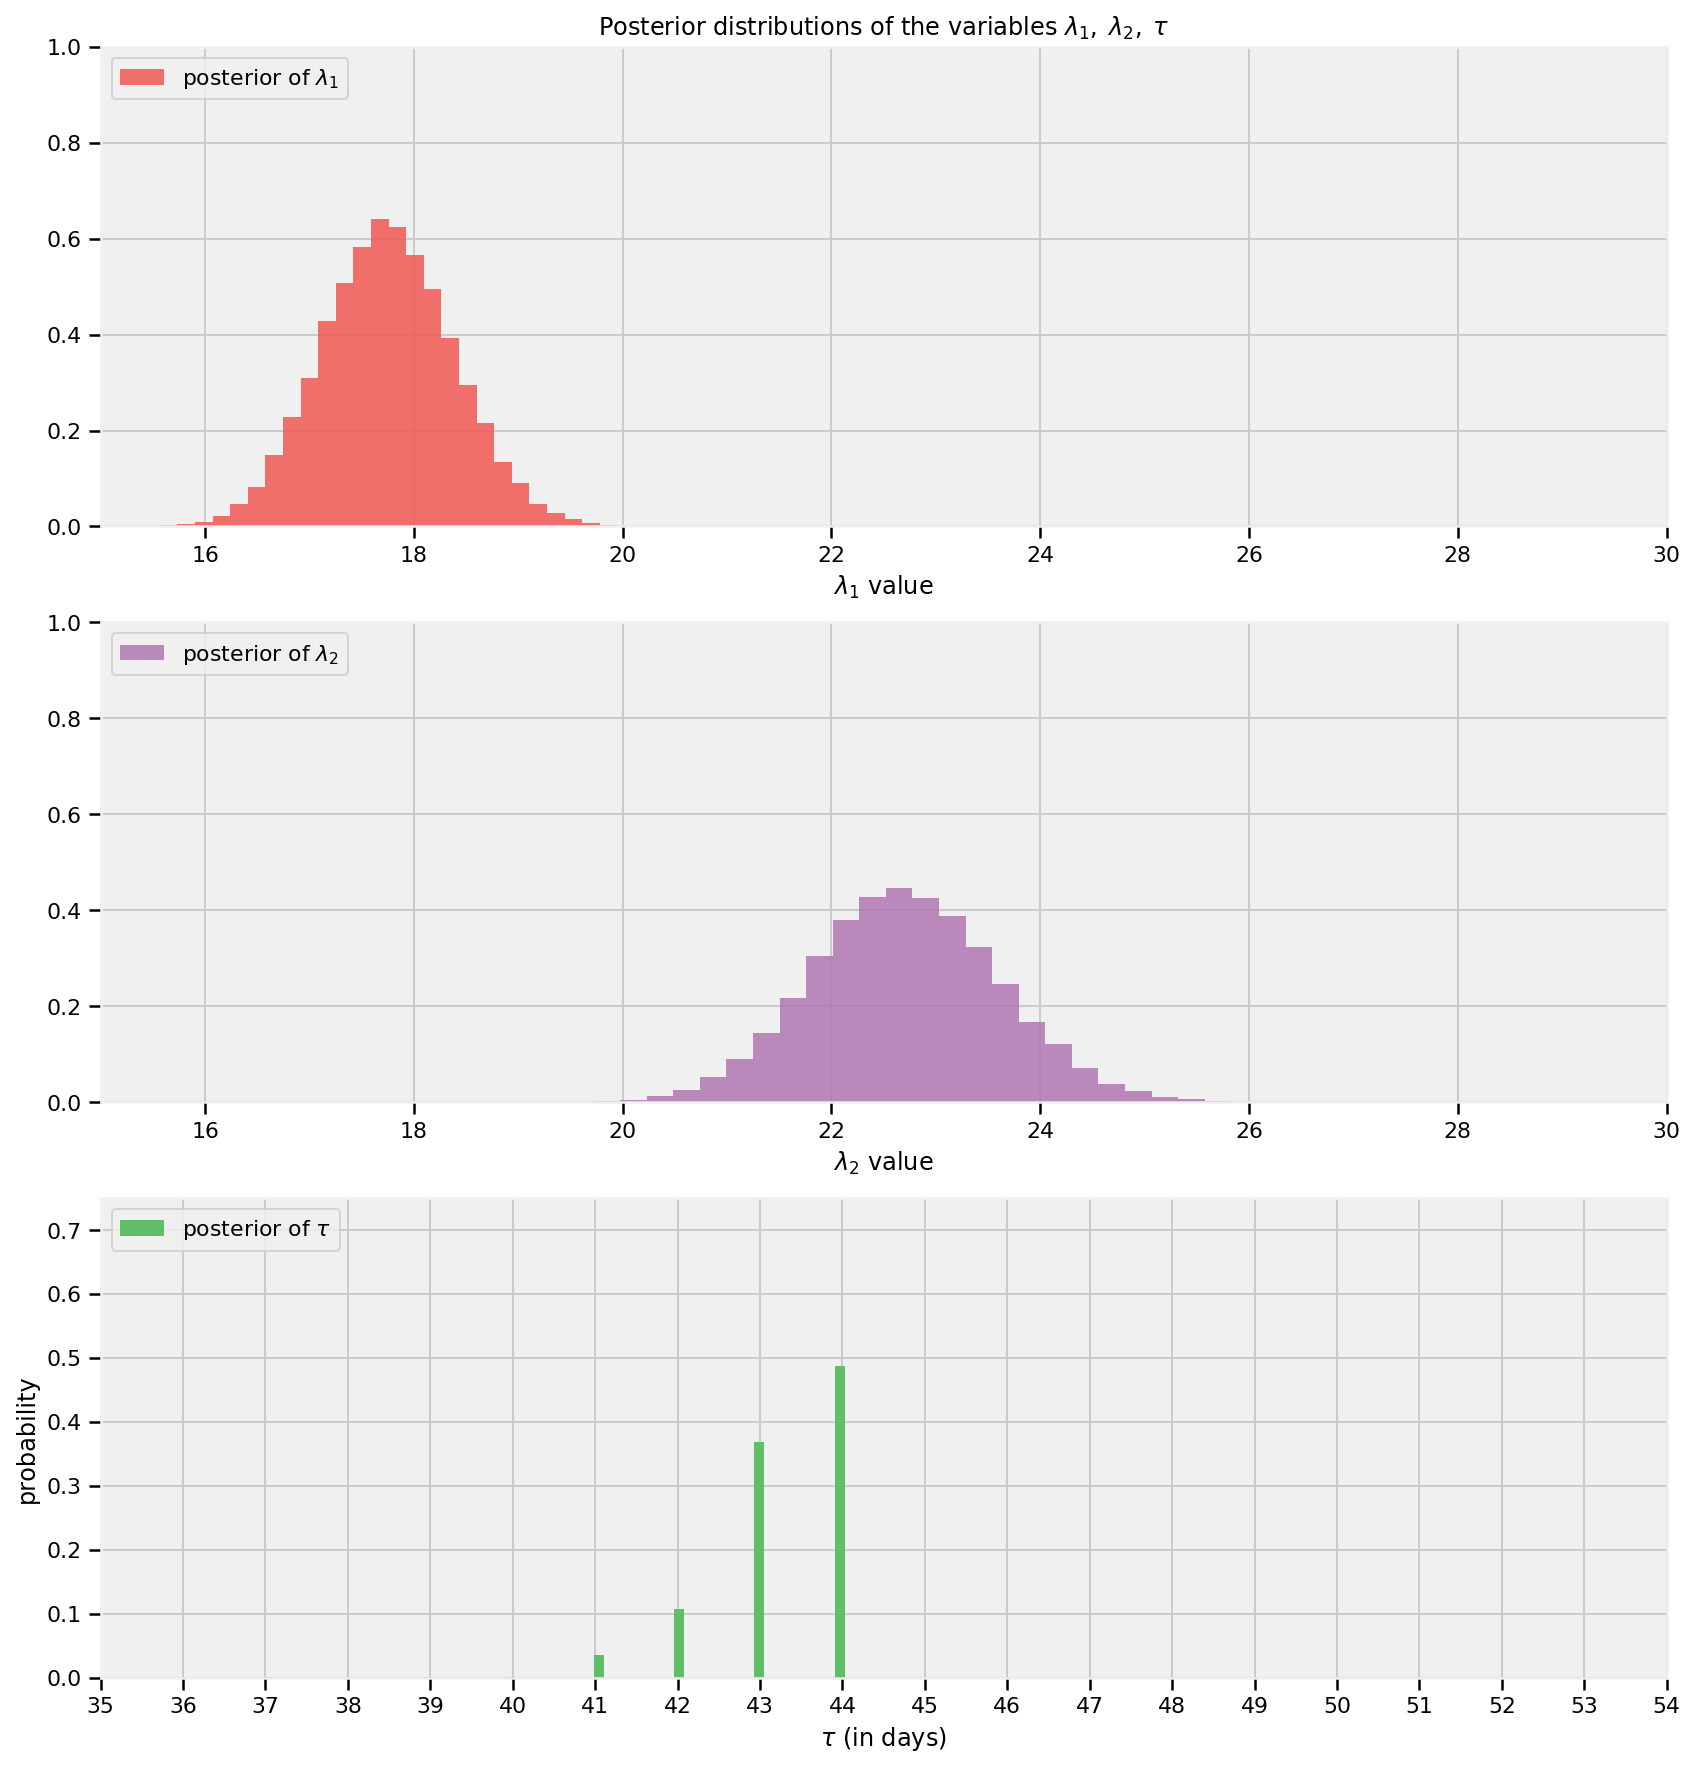

In [7]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=n_count_data_[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data_[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data_)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

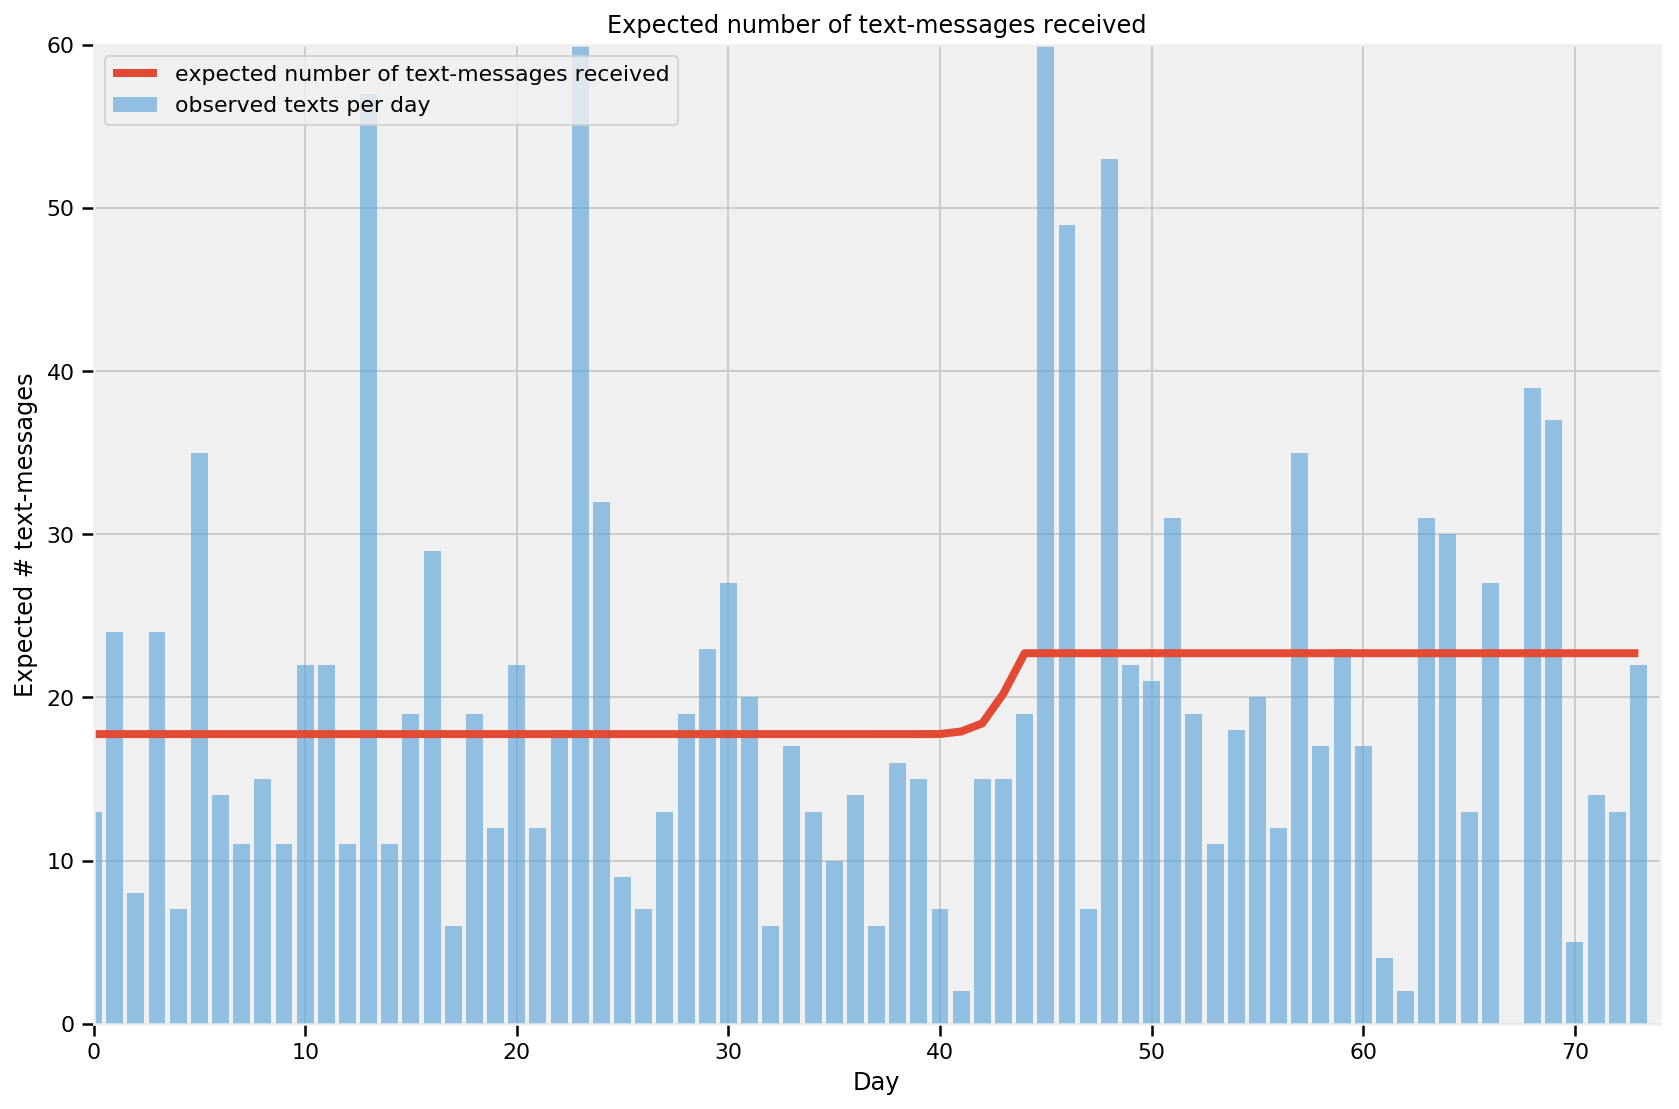

In [8]:
plt.figure(figsize=(12.5, 9))

for day in range(0, n_count_data_[0]):
    ix = day < tau_samples_
    expected_texts_per_day_[day] = (lambda_1_samples_[ix].sum()
                                    + lambda_2_samples_[~ix].sum()) / N_


plt.plot(range(n_count_data_[0]), expected_texts_per_day_, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data_[0])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data_)), count_data_, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")